# Demonstration of surrogate model capabilities

This is a simple jupyter notebook to demonstrate the autogluon surrogate model capability.

Author: Soheyl Massoudi <smassoudi@ethz.ch>

# Step 1: Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Step 2: Load and Convert Parquet Dataset

In [2]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")

/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset saved to ./data/airfoil_data.csv


In [3]:
dataset.column_names

['initial',
 'optimized',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [4]:
type(dataset['alpha'])

list

In [5]:
dataset['optimized'][1][0]

[1.0000194365938981,
 0.9897566593945221,
 0.9794544269870155,
 0.9691149136515305,
 0.9587402901643374,
 0.9483327419340516,
 0.9378945048481954,
 0.9274277968572291,
 0.9169348081262216,
 0.9064178020370062,
 0.8958790284346422,
 0.8853207187330372,
 0.8747448930482233,
 0.8641523083004454,
 0.8535437159737151,
 0.8429198967977035,
 0.8322817488654743,
 0.8216301200165563,
 0.8109658171290856,
 0.8002897285258235,
 0.7896027290487984,
 0.7789056461533759,
 0.7681993584263407,
 0.7574847603720507,
 0.7467626918304485,
 0.7360340279427758,
 0.7253037272659675,
 0.7145732743519277,
 0.7038473442473052,
 0.693126502752131,
 0.6824101435303259,
 0.6716976408464019,
 0.6609883248618159,
 0.6502815861483213,
 0.639576822934429,
 0.6288733614389102,
 0.6181705789840656,
 0.6074655520675161,
 0.5967516390819786,
 0.5860288162351749,
 0.5752975145222803,
 0.5645582221285628,
 0.5538114139478776,
 0.5430575344024076,
 0.5322970595788166,
 0.5215304770239737,
 0.5107583657552618,
 0.499988999525

# Step 3: Flatten columns and get X and Y datasets

In [6]:
def recursive_flatten(val):
    """
    Recursively flatten a nested list/tuple into a single list of values.
    E.g. [[x0, x1], [y0, y1]] -> [x0, x1, y0, y1].
    """
    if not isinstance(val, (list, tuple)):
        return [val]
    else:
        result = []
        for item in val:
            result.extend(recursive_flatten(item))
        return result

def flatten_list_columns_nested(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each column in `df` where the first row is a list,
    recursively flatten that column and expand into multiple new numeric columns.
    """
    import pandas as pd
    
    new_cols_list = []
    drop_cols = []
    
    for col in df.columns:
        first_value = df[col].iloc[0]
        # Check if the first row is a list/tuple --> likely all rows are lists
        if isinstance(first_value, (list, tuple)):
            # Flatten each row, store in a temporary list
            flattened_rows = [recursive_flatten(val) for val in df[col]]
            # Ensure consistent length across rows
            lengths = [len(row) for row in flattened_rows]
            unique_lengths = set(lengths)
            if len(unique_lengths) > 1:
                raise ValueError(
                    f"Column '{col}' has rows of varying lengths {unique_lengths}. "
                    "Cannot flatten consistently without special handling."
                )
            # Create new DataFrame with columns [col_0, col_1, ..., col_(n-1)]
            n = lengths[0]
            new_col_names = [f"{col}_{i}" for i in range(n)]
            expanded_df = pd.DataFrame(flattened_rows, columns=new_col_names)
            new_cols_list.append(expanded_df)
            drop_cols.append(col)
    
    if new_cols_list:
        # Drop original list-columns and concatenate new expanded columns
        df = pd.concat(
            [df.drop(columns=drop_cols).reset_index(drop=True)] + new_cols_list,
            axis=1
        )
    return df

# Flatten the nested list columns
df = flatten_list_columns_nested(df)


In [7]:
# The flattened columns for "optimized" will now appear as "optimized_0", "optimized_1", etc.
# Let's find all columns that start with "optimized_"
opt_cols = [col for col in df.columns if col.startswith("optimized_")]

# Or you can do them all if you know the exact count/structure

# Additional numeric columns we want
other_input_cols = ["mach", "reynolds", "alpha"]

# Combine them
feature_cols = opt_cols + other_input_cols

target_col = "cl_val"

# Create X and y
X = df[feature_cols].values
y = df[target_col].values


# Step 4: Split Inputs and Targets

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Suppose X is shape [n_samples, n_features], y is shape [n_samples]
# (Replace with your actual arrays from the flattened dataset.)

# 1) Split off test data (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Split the remaining into train and validation (25% of X_temp = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Optionally scale target as well
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


Train size: (448, 387), Val size: (150, 387), Test size: (150, 387)


# Step 5: Define a Pytorch Dataset and Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_scaled, y_train_scaled)
val_dataset   = TabularDataset(X_val_scaled,   y_val_scaled)
test_dataset  = TabularDataset(X_test_scaled,  y_test_scaled)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_scaled.shape[1]  # Number of features
hidden_dim = 64
model = SimpleRegressor(input_dim, hidden_dim, output_dim=1)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model.to(device)

num_epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []

best_model_weights = None
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # --- Training Loop ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch).squeeze(-1)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Loop ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch).squeeze(-1)
            loss = criterion(predictions, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        # Store best weights
        best_model_weights = model.state_dict()
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f"Validation loss has not improved for {patience} epochs. Stopping early.")
        break

# --- After training, restore the best weights ---
print(f"Best validation loss = {best_val_loss:.4f} at epoch {best_epoch+1}.")
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)



Using device: mps
Epoch 1/100 - Train Loss: 0.7779, Val Loss: 0.6491
Epoch 2/100 - Train Loss: 0.5426, Val Loss: 0.5571
Epoch 3/100 - Train Loss: 0.4203, Val Loss: 0.4517
Epoch 4/100 - Train Loss: 0.3566, Val Loss: 0.5126
Epoch 5/100 - Train Loss: 0.2885, Val Loss: 0.3740
Epoch 6/100 - Train Loss: 0.2311, Val Loss: 0.3203
Epoch 7/100 - Train Loss: 0.2069, Val Loss: 0.3497
Epoch 8/100 - Train Loss: 0.1813, Val Loss: 0.2814
Epoch 9/100 - Train Loss: 0.1509, Val Loss: 0.2585
Epoch 10/100 - Train Loss: 0.1446, Val Loss: 0.2606
Epoch 11/100 - Train Loss: 0.1486, Val Loss: 0.2190
Epoch 12/100 - Train Loss: 0.1236, Val Loss: 0.1765
Epoch 13/100 - Train Loss: 0.1032, Val Loss: 0.2197
Epoch 14/100 - Train Loss: 0.1139, Val Loss: 0.1706
Epoch 15/100 - Train Loss: 0.0833, Val Loss: 0.1646
Epoch 16/100 - Train Loss: 0.0799, Val Loss: 0.1505
Epoch 17/100 - Train Loss: 0.0682, Val Loss: 0.1327
Epoch 18/100 - Train Loss: 0.0685, Val Loss: 0.1336
Epoch 19/100 - Train Loss: 0.0633, Val Loss: 0.1169
Epo

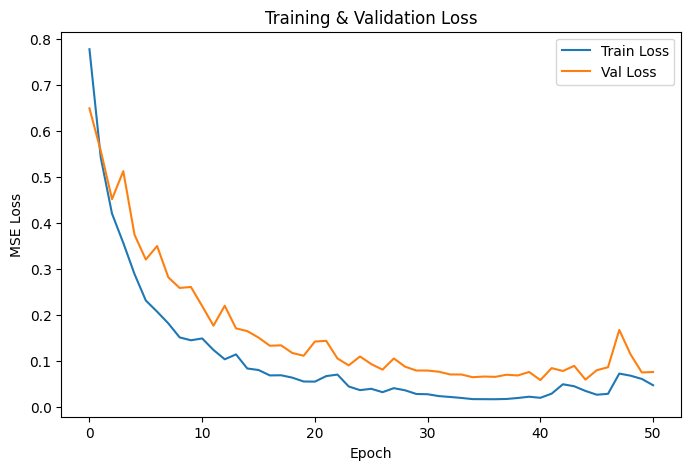

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


# Step 6: Predictions and Inverse Transform

In [11]:
model.eval()
test_preds_scaled = []
test_targets_scaled = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch).squeeze(-1)

        test_preds_scaled.append(preds.cpu().numpy())
        test_targets_scaled.append(y_batch.cpu().numpy())

test_preds_scaled = np.concatenate(test_preds_scaled)
test_targets_scaled = np.concatenate(test_targets_scaled)

# Inverse transform if you scaled the target
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
test_targets = scaler_y.inverse_transform(test_targets_scaled.reshape(-1, 1)).flatten()

# Calculate the final test MSE or RMSE
mse_test = np.mean((test_preds - test_targets)**2)
rmse_test = np.sqrt(mse_test)
print(f"Test MSE:  {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# Display a small sample of true vs predicted
print("\nSample of predictions vs true values:")
for i in range(5):
    print(f"Predicted: {test_preds[i]:.4f},  True: {test_targets[i]:.4f},  Diff: {test_preds[i] - test_targets[i]:.4f}")


Test MSE:  0.0031
Test RMSE: 0.0561

Sample of predictions vs true values:
Predicted: 0.7420,  True: 0.7862,  Diff: -0.0443
Predicted: 0.9102,  True: 0.9167,  Diff: -0.0065
Predicted: 0.7486,  True: 0.7405,  Diff: 0.0082
Predicted: 0.8529,  True: 0.8399,  Diff: 0.0130
Predicted: 0.8227,  True: 0.8537,  Diff: -0.0310


In [12]:
# Step 1: Setup

In [17]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")



/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 47/47 [00:00<00:00, 21561.01 examples/s]


Dataset saved to ./data/airfoil_data.csv


In [2]:
import pandas as pd

# Load the dataset from Hugging Face's raw CSV URL
csv_url = "https://huggingface.co/datasets/IDEALLab/power_electronics_v0/resolve/main/dataset_v0_1.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_url)

# Display the first few rows
print(df.head())

# Save it locally if needed
df.to_csv("./data/power_electronics_v0_1.csv", index=False)


         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  


In [32]:
type(df["initial_design"][0][1])


list

Type of df['initial_design'][0]: <class 'list'>
Type of first element (x coords): <class 'list'>
Type of second element (y coords): <class 'list'>


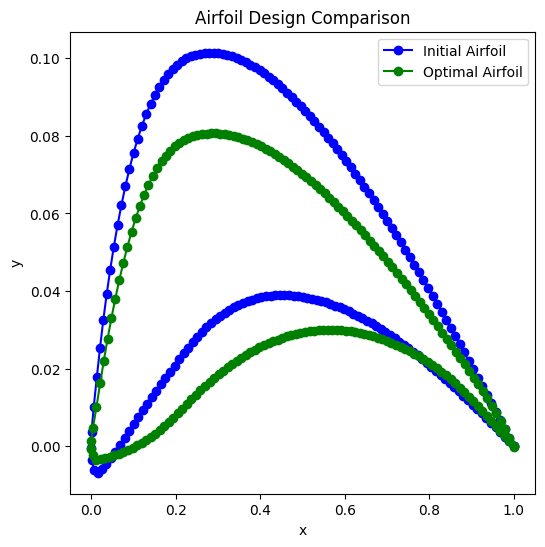

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Get the first entry for initial and optimal designs
init_design = df["initial_design"].iloc[0]
opt_design  = df["optimal_design"].iloc[0]

# Verify the structure:
print("Type of df['initial_design'][0]:", type(init_design))
print("Type of first element (x coords):", type(init_design[0]))
print("Type of second element (y coords):", type(init_design[1]))

# Pair x and y coordinates for initial and optimal designs
init_coords = np.column_stack((init_design[0], init_design[1]))
opt_coords  = np.column_stack((opt_design[0], opt_design[1]))

# Plot the designs
plt.figure(figsize=(6,6))
plt.plot(init_coords[:,0], init_coords[:,1], 'bo-', label="Initial Airfoil")
plt.plot(opt_coords[:,0], opt_coords[:,1], 'go-', label="Optimal Airfoil")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Airfoil Design Comparison")
plt.legend()
plt.show()


## Step 

## Step 2: Load surrogate model from engiopt

In [18]:
dataset.column_names

['initial_design',
 'optimal_design',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [ ]:
print(df.head())

         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  


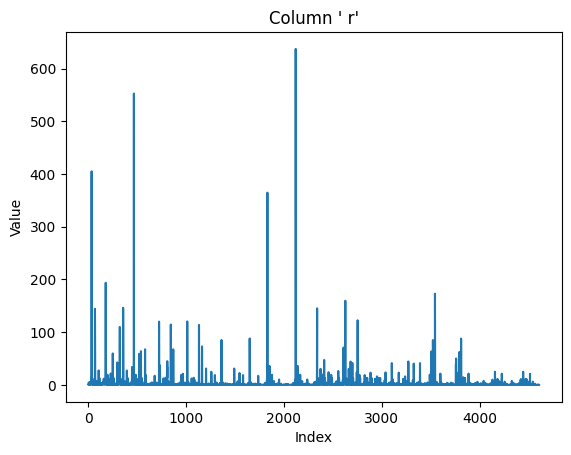

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

df[' r'].plot(kind='line', title="Column ' r'")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


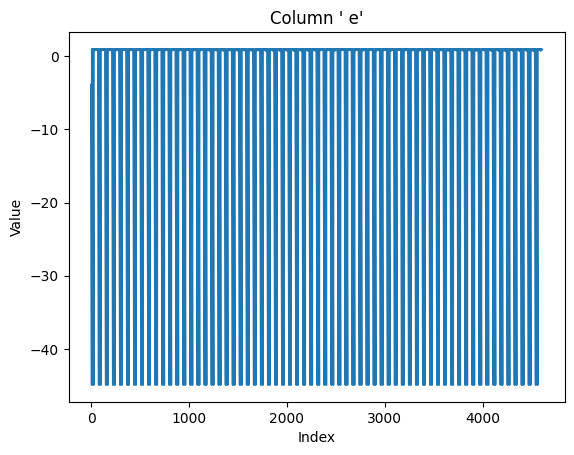

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

df[' e'].plot(kind='line', title="Column ' e'")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


In [5]:
df.describe()


,C1,C2,C3,C4,C5,C6,L1,L2,L3,T1,g,r,e
count,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4.608000e+03,4608.000000,4608.000000
mean,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000500,0.000500,0.000500,0.500000,1.779687e-01,2.548686,-5.418452
std,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000500,0.000500,0.000500,0.258227,2.262546e-01,17.426358,12.806794
min,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.100000,7.770340e-07,0.004893,-44.932700
25%,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.300000,1.167198e-02,0.160791,-0.455450
50%,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000500,0.000500,0.000500,0.500000,6.475145e-02,0.409126,0.882925
75%,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.001000,0.001000,0.001000,0.700000,2.905664e-01,1.147634,0.950271
max,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.001000,0.001000,0.001000,0.900000,9.619789e-01,637.193300,0.992604


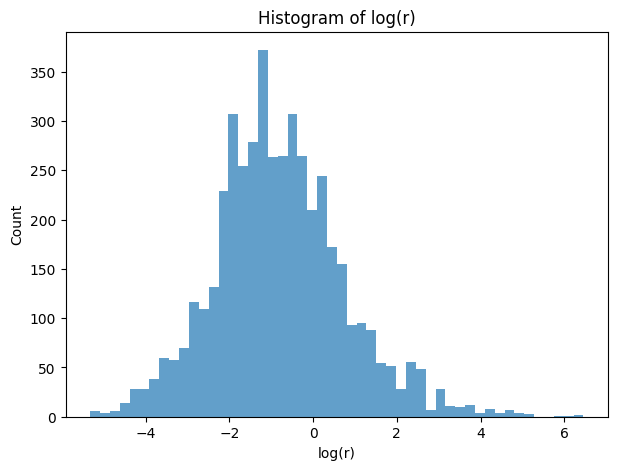

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Compute log(r + 1e-8)
log_r = np.log(df[' r'])

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(log_r, bins=50, alpha=0.7)
plt.xlabel("log(r)")
plt.ylabel("Count")
plt.title("Histogram of log(r)")
plt.show()


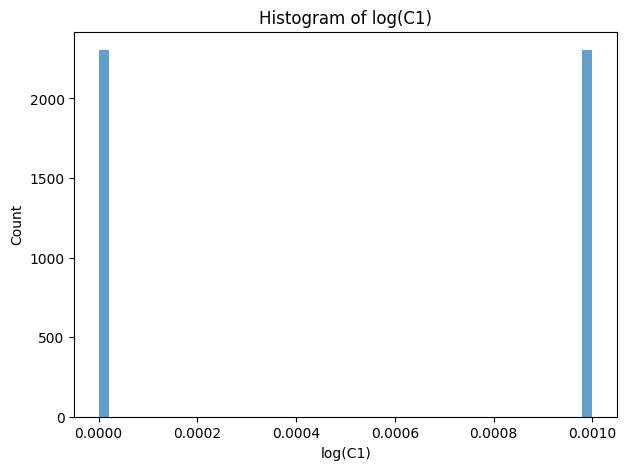

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Compute log(r + 1e-8)
log_r = df[' L3']

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(log_r, bins=50, alpha=0.7)
plt.xlabel("log(C1)")
plt.ylabel("Count")
plt.title("Histogram of log(C1)")
plt.show()


In [19]:
df.columns

Index(['C1', ' C2', ' C3', ' C4', ' C5', ' C6', ' L1', ' L2', ' L3', ' T1',
       ' g', ' r', ' e'],
      dtype='object')

In [14]:
!python ./engiopt/shape2shape_leastV_vae.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --nondim_map '{"C2": "C1", "C3": "C1", "C4": "C1", "C5": "C1", "C6": "C1", "L2": "L1", "L3": "L1"}' \
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 5e-5 \
    --no-structured \
    --hidden_layers 3 \
    --hidden_size 64 \
    --latent_dim 8 \
    --n_epochs 4000 \
    --batch_size 32 \
    --patience 500 \
    --scale_target \
    --no-track \
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001  ...  0.2  0.410832  1.152453  -9.022484
2  0.000001  0.000001  0.000001  0.000001  ...  0.3  0.353193  1.521469 -14.144002
3  0.000001  0.000001  0.000001  0.000001  ...  0.4  0.256083  2.190335 -19.268402
4  0.000001  0.000001  0.000001  0.000001  ...  0.5  0.147918  3.205281 -24.395419

[5 rows x 13 columns]
Applied nondimensionalization using map: {'C2': 'C1', 'C3': 'C1', 'C4': 'C1', 'C5': 'C1', 'C6': 'C1', 'L2': 'L1', 'L3': 'L1'}
Applied log-transform to column 'r'
[Epoch 1/4000] Train Loss: 0.4053, Val Loss: 0.4019
[Epoch 2/4000] Train Loss: 0.3954, Val Loss: 0.3910
[Epoch 3/4000] Train Loss: 0.3826, Val Loss: 0.3762
[Epoch 4/4000] Train Loss: 0.3659, Val Loss: 0.3566
[Epoch 5/4000] Train Loss: 0.3455, Val Loss: 0.3344
[Epoch 6/4000] Train Loss: 0.3235, Val 

In [ ]:
# better cause circuit as categorical values so dimless i think not needed
!python ./engiopt/shape2shape_leastV_vae.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 5e-5 \
    --no-structured \
    --hidden_layers 3 \
    --hidden_size 64 \
    --latent_dim 8 \
    --n_epochs 4000 \
    --batch_size 32 \
    --patience 500 \
    --scale_target \
    --no-track \
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001  ...  0.2  0.410832  1.152453  -9.022484
2  0.000001  0.000001  0.000001  0.000001  ...  0.3  0.353193  1.521469 -14.144002
3  0.000001  0.000001  0.000001  0.000001  ...  0.4  0.256083  2.190335 -19.268402
4  0.000001  0.000001  0.000001  0.000001  ...  0.5  0.147918  3.205281 -24.395419

[5 rows x 13 columns]
Traceback (most recent call last):
  File "/Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/./engiopt/shape2shape_leastV_vae.py", line 828, in <module>
    main(args)
  File "/Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/./engiopt/shape2shape_leastV_vae.py", line 413, in main
    raise ValueError(f"Missing target column: {args.target_col}")
ValueError: Missing target column: cl_val


In [43]:
# better cause circuit as categorical values so dimless i think not needed
!python ./engiopt/shape2shape_leastV_vae_hybsm.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 1e-3 \
    --no-structured \
    --hidden_layers 2 \
    --hidden_size 128 \
    --latent_dim 8 \
    --n_epochs 500 \
    --batch_size 64 \
    --patience 200 \
    --scale_target \
    --track \
    --wandb_project "shape2shape_leastV_vae_hybsm_pe"\
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

wandb: Currently logged in as: smassoudi (smassoudi-eth-z-rich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.5
wandb: Run data is saved locally in /Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/wandb/run-20250321_140316-8izlkqbu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run power_electronics_v0_1.csv__seed18__2025-03-21-14-03-15
wandb: ⭐️ View project at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe
wandb: 🚀 View run at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe/runs/8izlkqbu
Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001  ...

[INFO 03-21 14:53:29] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-21 14:53:29] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter hidden_layers. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/service/utils/instantiation.py:258: AxParameterWarning: `is_ordered` is not specified for `ChoiceParameter` "hidden_layers". Defaulting to `True`  since the parameter is not of type string.. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction. Note that choice parameters with exactly 2 choices are always considered ordered and that the user-supplied `is_ordered`

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

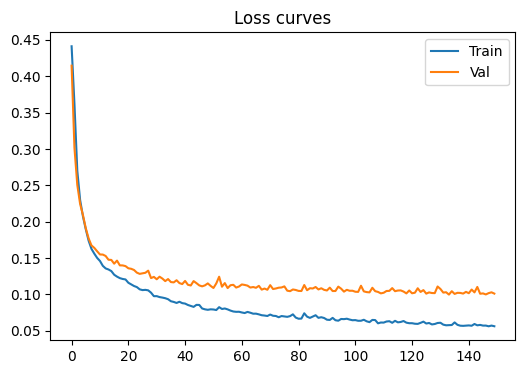

Test samples:
Sample   0: Pred=0.1101, True=0.0827
Sample   1: Pred=0.1843, True=0.2127
Sample   2: Pred=1.7864, True=0.9860
Sample   3: Pred=0.5115, True=0.6338
Sample   4: Pred=0.0457, True=0.0199
Sample   5: Pred=0.1598, True=0.1615
Sample   6: Pred=0.5415, True=1.5235
Sample   7: Pred=0.1112, True=0.2015
Sample   8: Pred=0.8954, True=0.9216
Sample   9: Pred=1.7766, True=1.0129
Sample  10: Pred=4.6810, True=6.1867
Sample  11: Pred=0.1474, True=0.1766
Sample  12: Pred=0.1752, True=0.1623
Sample  13: Pred=0.4197, True=0.3659
Sample  14: Pred=0.2051, True=0.1767
Sample  15: Pred=0.2234, True=0.2197
Sample  16: Pred=0.0968, True=0.2002
Sample  17: Pred=0.1574, True=0.2295
Sample  18: Pred=0.5963, True=0.5474
Sample  19: Pred=0.1718, True=0.0984
Sample  20: Pred=0.0339, True=0.0502
Sample  21: Pred=5.3231, True=3.2123
Sample  22: Pred=0.1365, True=0.1116
Sample  23: Pred=0.4629, True=0.5464
Sample  24: Pred=0.0658, True=0.0712
Sample  25: Pred=2.3126, True=2.1653
Sample  26: Pred=10.9981

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
train_loss,█▇▄▄▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▂▂▂▂▂▁▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.05635
val_loss,0.10122


[INFO 03-21 14:54:00] ax.service.managed_loop: Running optimization trial 2...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

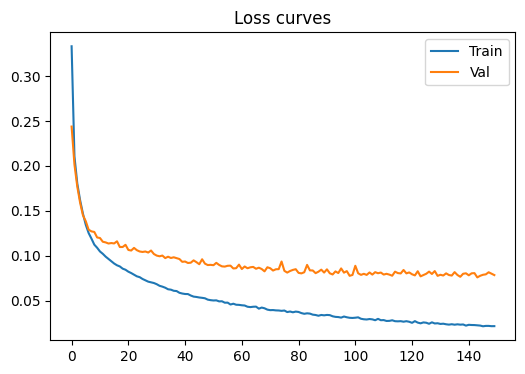

Test samples:
Sample   0: Pred=0.0717, True=0.0827
Sample   1: Pred=0.1571, True=0.2127
Sample   2: Pred=2.2078, True=0.9860
Sample   3: Pred=0.4650, True=0.6338
Sample   4: Pred=0.0299, True=0.0199
Sample   5: Pred=0.1324, True=0.1615
Sample   6: Pred=0.5271, True=1.5235
Sample   7: Pred=0.1321, True=0.2015
Sample   8: Pred=0.6950, True=0.9216
Sample   9: Pred=5.0336, True=1.0129
Sample  10: Pred=2.8746, True=6.1867
Sample  11: Pred=0.1611, True=0.1766
Sample  12: Pred=0.1713, True=0.1623
Sample  13: Pred=0.3013, True=0.3659
Sample  14: Pred=0.1358, True=0.1767
Sample  15: Pred=0.2090, True=0.2197
Sample  16: Pred=0.1239, True=0.2002
Sample  17: Pred=0.1035, True=0.2295
Sample  18: Pred=0.5081, True=0.5474
Sample  19: Pred=0.5236, True=0.0984
Sample  20: Pred=0.0404, True=0.0502
Sample  21: Pred=7.9040, True=3.2123
Sample  22: Pred=0.0980, True=0.1116
Sample  23: Pred=0.4702, True=0.5464
Sample  24: Pred=0.0582, True=0.0712
Sample  25: Pred=2.4164, True=2.1653
Sample  26: Pred=10.5458

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇██
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▄▄▃▃▄▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.02157
val_loss,0.07843


[INFO 03-21 14:56:26] ax.service.managed_loop: Running optimization trial 3...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

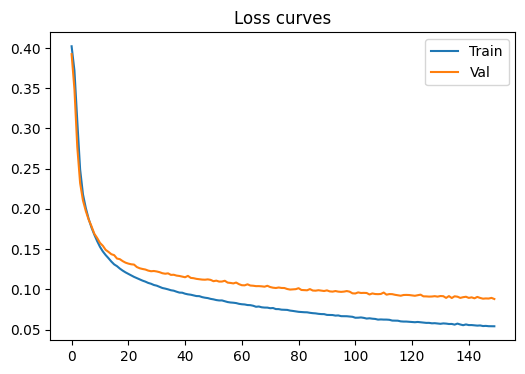

Test samples:
Sample   0: Pred=0.1285, True=0.0827
Sample   1: Pred=0.1701, True=0.2127
Sample   2: Pred=2.3432, True=0.9860
Sample   3: Pred=0.3680, True=0.6338
Sample   4: Pred=0.0396, True=0.0199
Sample   5: Pred=0.1071, True=0.1615
Sample   6: Pred=0.3830, True=1.5235
Sample   7: Pred=0.0928, True=0.2015
Sample   8: Pred=0.8726, True=0.9216
Sample   9: Pred=5.2598, True=1.0129
Sample  10: Pred=3.6348, True=6.1867
Sample  11: Pred=0.2112, True=0.1766
Sample  12: Pred=0.1846, True=0.1623
Sample  13: Pred=0.3819, True=0.3659
Sample  14: Pred=0.1511, True=0.1767
Sample  15: Pred=0.2529, True=0.2197
Sample  16: Pred=0.1993, True=0.2002
Sample  17: Pred=0.1452, True=0.2295
Sample  18: Pred=0.6857, True=0.5474
Sample  19: Pred=0.1043, True=0.0984
Sample  20: Pred=0.0318, True=0.0502
Sample  21: Pred=3.4031, True=3.2123
Sample  22: Pred=0.1281, True=0.1116
Sample  23: Pred=0.5966, True=0.5464
Sample  24: Pred=0.0597, True=0.0712
Sample  25: Pred=2.0532, True=2.1653
Sample  26: Pred=9.3981,

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
train_loss,█▇▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.05413
val_loss,0.08802


[INFO 03-21 14:57:36] ax.service.managed_loop: Running optimization trial 4...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

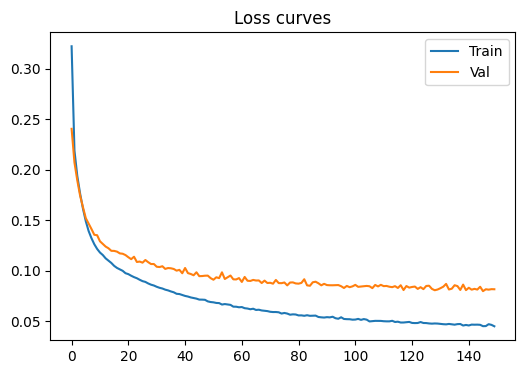

Test samples:
Sample   0: Pred=0.1032, True=0.0827
Sample   1: Pred=0.2381, True=0.2127
Sample   2: Pred=3.0391, True=0.9860
Sample   3: Pred=0.5166, True=0.6338
Sample   4: Pred=0.0300, True=0.0199
Sample   5: Pred=0.1703, True=0.1615
Sample   6: Pred=0.5465, True=1.5235
Sample   7: Pred=0.1234, True=0.2015
Sample   8: Pred=1.3190, True=0.9216
Sample   9: Pred=2.9825, True=1.0129
Sample  10: Pred=3.5542, True=6.1867
Sample  11: Pred=0.1461, True=0.1766
Sample  12: Pred=0.1615, True=0.1623
Sample  13: Pred=0.3835, True=0.3659
Sample  14: Pred=0.2197, True=0.1767
Sample  15: Pred=0.2440, True=0.2197
Sample  16: Pred=0.1715, True=0.2002
Sample  17: Pred=0.2083, True=0.2295
Sample  18: Pred=0.6755, True=0.5474
Sample  19: Pred=0.2233, True=0.0984
Sample  20: Pred=0.0275, True=0.0502
Sample  21: Pred=3.8714, True=3.2123
Sample  22: Pred=0.1146, True=0.1116
Sample  23: Pred=0.5394, True=0.5464
Sample  24: Pred=0.0503, True=0.0712
Sample  25: Pred=1.6881, True=2.1653
Sample  26: Pred=10.8095

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.045
val_loss,0.08162


[INFO 03-21 14:59:28] ax.service.managed_loop: Running optimization trial 5...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

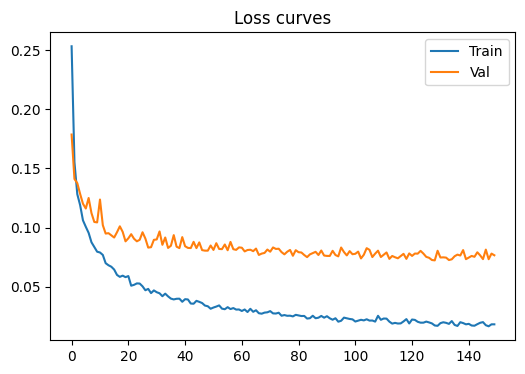

Test samples:
Sample   0: Pred=0.0976, True=0.0827
Sample   1: Pred=0.2056, True=0.2127
Sample   2: Pred=2.3305, True=0.9860
Sample   3: Pred=0.6296, True=0.6338
Sample   4: Pred=0.0342, True=0.0199
Sample   5: Pred=0.1549, True=0.1615
Sample   6: Pred=1.0066, True=1.5235
Sample   7: Pred=0.2233, True=0.2015
Sample   8: Pred=1.2851, True=0.9216
Sample   9: Pred=2.3818, True=1.0129
Sample  10: Pred=2.6649, True=6.1867
Sample  11: Pred=0.1699, True=0.1766
Sample  12: Pred=0.1496, True=0.1623
Sample  13: Pred=0.3308, True=0.3659
Sample  14: Pred=0.1611, True=0.1767
Sample  15: Pred=0.2344, True=0.2197
Sample  16: Pred=0.2298, True=0.2002
Sample  17: Pred=0.1570, True=0.2295
Sample  18: Pred=0.5182, True=0.5474
Sample  19: Pred=0.0788, True=0.0984
Sample  20: Pred=0.0386, True=0.0502
Sample  21: Pred=7.0746, True=3.2123
Sample  22: Pred=0.1245, True=0.1116
Sample  23: Pred=0.5306, True=0.5464
Sample  24: Pred=0.0837, True=0.0712
Sample  25: Pred=2.1982, True=2.1653
Sample  26: Pred=13.3567

epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▃▃▃▄▂▄▂▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▂▂▁▁▁▁▂▁▁
epoch,149
train_loss,0.01823
val_loss,0.07662


[INFO 03-21 15:02:09] ax.service.managed_loop: Running optimization trial 6...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

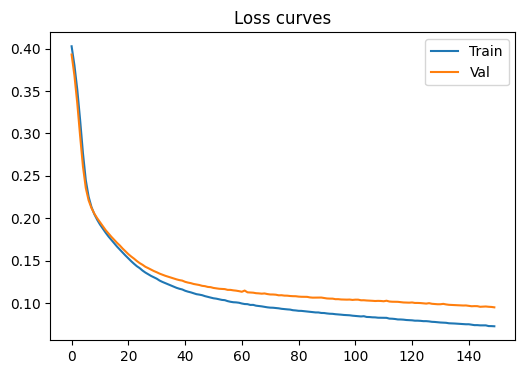

Test samples:
Sample   0: Pred=0.1036, True=0.0827
Sample   1: Pred=0.1347, True=0.2127
Sample   2: Pred=2.9840, True=0.9860
Sample   3: Pred=0.6833, True=0.6338
Sample   4: Pred=0.0439, True=0.0199
Sample   5: Pred=0.1348, True=0.1615
Sample   6: Pred=0.4867, True=1.5235
Sample   7: Pred=0.1247, True=0.2015
Sample   8: Pred=0.6857, True=0.9216
Sample   9: Pred=3.9505, True=1.0129
Sample  10: Pred=2.2526, True=6.1867
Sample  11: Pred=0.2684, True=0.1766
Sample  12: Pred=0.1241, True=0.1623
Sample  13: Pred=0.3879, True=0.3659
Sample  14: Pred=0.1797, True=0.1767
Sample  15: Pred=0.3642, True=0.2197
Sample  16: Pred=0.1207, True=0.2002
Sample  17: Pred=0.1640, True=0.2295
Sample  18: Pred=0.5772, True=0.5474
Sample  19: Pred=0.3382, True=0.0984
Sample  20: Pred=0.0298, True=0.0502
Sample  21: Pred=2.1735, True=3.2123
Sample  22: Pred=0.1054, True=0.1116
Sample  23: Pred=0.5129, True=0.5464
Sample  24: Pred=0.0607, True=0.0712
Sample  25: Pred=1.2207, True=2.1653
Sample  26: Pred=10.2327

epoch,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
train_loss,█▇▇▇▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.07291
val_loss,0.09522


[INFO 03-21 15:02:41] ax.service.managed_loop: Running optimization trial 7...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

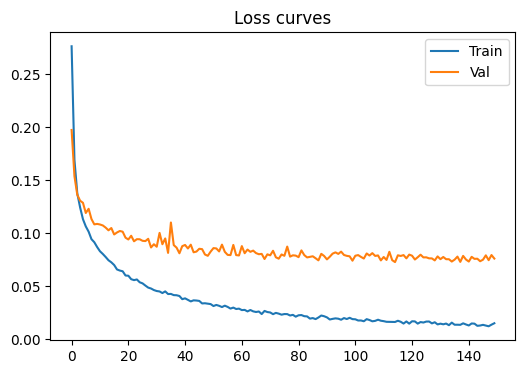

Test samples:
Sample   0: Pred=0.0816, True=0.0827
Sample   1: Pred=0.2240, True=0.2127
Sample   2: Pred=1.3370, True=0.9860
Sample   3: Pred=0.5310, True=0.6338
Sample   4: Pred=0.0258, True=0.0199
Sample   5: Pred=0.1539, True=0.1615
Sample   6: Pred=1.1898, True=1.5235
Sample   7: Pred=0.1881, True=0.2015
Sample   8: Pred=0.8291, True=0.9216
Sample   9: Pred=5.4362, True=1.0129
Sample  10: Pred=1.7376, True=6.1867
Sample  11: Pred=0.1101, True=0.1766
Sample  12: Pred=0.1574, True=0.1623
Sample  13: Pred=0.4053, True=0.3659
Sample  14: Pred=0.2162, True=0.1767
Sample  15: Pred=0.1919, True=0.2197
Sample  16: Pred=0.1825, True=0.2002
Sample  17: Pred=0.1208, True=0.2295
Sample  18: Pred=0.5167, True=0.5474
Sample  19: Pred=0.2588, True=0.0984
Sample  20: Pred=0.0362, True=0.0502
Sample  21: Pred=8.8136, True=3.2123
Sample  22: Pred=0.1004, True=0.1116
Sample  23: Pred=0.4437, True=0.5464
Sample  24: Pred=0.0446, True=0.0712
Sample  25: Pred=3.3138, True=2.1653
Sample  26: Pred=10.8248

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▇▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▅▄▃▃▃▃▂▄▅▂▃▂▂▂▃▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▂
epoch,149
train_loss,0.01524
val_loss,0.07615


[INFO 03-21 15:08:01] ax.service.managed_loop: Running optimization trial 8...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

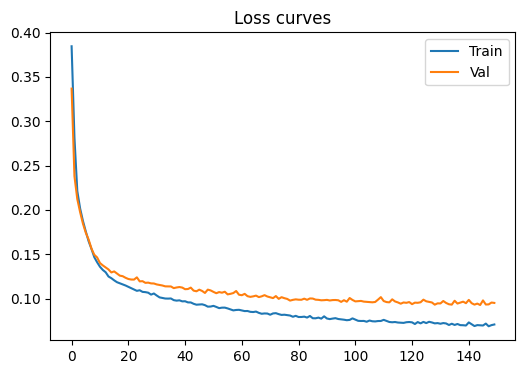

Test samples:
Sample   0: Pred=0.0644, True=0.0827
Sample   1: Pred=0.1361, True=0.2127
Sample   2: Pred=2.5339, True=0.9860
Sample   3: Pred=0.6999, True=0.6338
Sample   4: Pred=0.0347, True=0.0199
Sample   5: Pred=0.1700, True=0.1615
Sample   6: Pred=0.6876, True=1.5235
Sample   7: Pred=0.1269, True=0.2015
Sample   8: Pred=0.5771, True=0.9216
Sample   9: Pred=3.3123, True=1.0129
Sample  10: Pred=4.0299, True=6.1867
Sample  11: Pred=0.1631, True=0.1766
Sample  12: Pred=0.1654, True=0.1623
Sample  13: Pred=0.4513, True=0.3659
Sample  14: Pred=0.2013, True=0.1767
Sample  15: Pred=0.1661, True=0.2197
Sample  16: Pred=0.1486, True=0.2002
Sample  17: Pred=0.1281, True=0.2295
Sample  18: Pred=0.6478, True=0.5474
Sample  19: Pred=0.1133, True=0.0984
Sample  20: Pred=0.0342, True=0.0502
Sample  21: Pred=1.6675, True=3.2123
Sample  22: Pred=0.1064, True=0.1116
Sample  23: Pred=0.3612, True=0.5464
Sample  24: Pred=0.0552, True=0.0712
Sample  25: Pred=1.6776, True=2.1653
Sample  26: Pred=9.1701,

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.07079
val_loss,0.09511


[INFO 03-21 15:08:33] ax.service.managed_loop: Running optimization trial 9...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

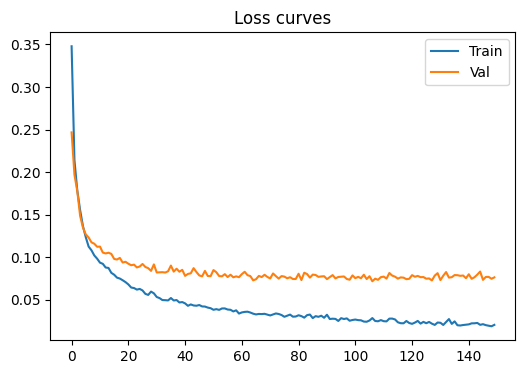

Test samples:
Sample   0: Pred=0.0860, True=0.0827
Sample   1: Pred=0.2352, True=0.2127
Sample   2: Pred=0.8652, True=0.9860
Sample   3: Pred=0.6381, True=0.6338
Sample   4: Pred=0.0291, True=0.0199
Sample   5: Pred=0.1369, True=0.1615
Sample   6: Pred=0.4028, True=1.5235
Sample   7: Pred=0.2635, True=0.2015
Sample   8: Pred=0.8281, True=0.9216
Sample   9: Pred=2.8375, True=1.0129
Sample  10: Pred=2.4718, True=6.1867
Sample  11: Pred=0.1540, True=0.1766
Sample  12: Pred=0.1602, True=0.1623
Sample  13: Pred=0.4054, True=0.3659
Sample  14: Pred=0.2415, True=0.1767
Sample  15: Pred=0.1598, True=0.2197
Sample  16: Pred=0.1422, True=0.2002
Sample  17: Pred=0.1181, True=0.2295
Sample  18: Pred=0.5156, True=0.5474
Sample  19: Pred=0.2210, True=0.0984
Sample  20: Pred=0.0320, True=0.0502
Sample  21: Pred=6.4113, True=3.2123
Sample  22: Pred=0.1049, True=0.1116
Sample  23: Pred=0.5223, True=0.5464
Sample  24: Pred=0.0768, True=0.0712
Sample  25: Pred=2.5506, True=2.1653
Sample  26: Pred=16.3648

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
train_loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.02044
val_loss,0.07625


[INFO 03-21 15:09:11] ax.service.managed_loop: Running optimization trial 10...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

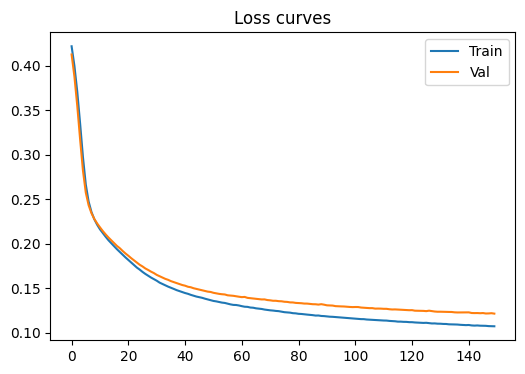

Test samples:
Sample   0: Pred=0.0655, True=0.0827
Sample   1: Pred=0.1504, True=0.2127
Sample   2: Pred=2.6352, True=0.9860
Sample   3: Pred=0.7002, True=0.6338
Sample   4: Pred=0.0404, True=0.0199
Sample   5: Pred=0.1349, True=0.1615
Sample   6: Pred=0.3397, True=1.5235
Sample   7: Pred=0.1231, True=0.2015
Sample   8: Pred=1.1656, True=0.9216
Sample   9: Pred=3.2020, True=1.0129
Sample  10: Pred=1.8373, True=6.1867
Sample  11: Pred=0.3751, True=0.1766
Sample  12: Pred=0.1367, True=0.1623
Sample  13: Pred=0.3527, True=0.3659
Sample  14: Pred=0.1525, True=0.1767
Sample  15: Pred=0.3571, True=0.2197
Sample  16: Pred=0.1320, True=0.2002
Sample  17: Pred=0.2035, True=0.2295
Sample  18: Pred=0.5633, True=0.5474
Sample  19: Pred=0.2887, True=0.0984
Sample  20: Pred=0.0281, True=0.0502
Sample  21: Pred=1.7188, True=3.2123
Sample  22: Pred=0.1227, True=0.1116
Sample  23: Pred=0.5057, True=0.5464
Sample  24: Pred=0.1103, True=0.0712
Sample  25: Pred=1.2252, True=2.1653
Sample  26: Pred=10.2411

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.10722
val_loss,0.12143


[INFO 03-21 15:10:06] ax.service.managed_loop: Running optimization trial 11...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 0
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

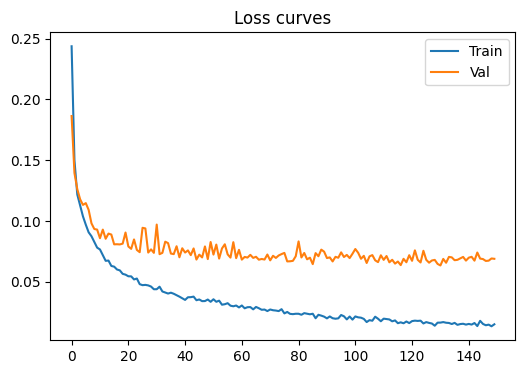

Test samples:
Sample   0: Pred=0.1156, True=0.0827
Sample   1: Pred=0.1840, True=0.2127
Sample   2: Pred=0.7718, True=0.9860
Sample   3: Pred=0.7381, True=0.6338
Sample   4: Pred=0.0247, True=0.0199
Sample   5: Pred=0.1721, True=0.1615
Sample   6: Pred=0.2398, True=1.5235
Sample   7: Pred=0.2279, True=0.2015
Sample   8: Pred=1.0307, True=0.9216
Sample   9: Pred=2.2532, True=1.0129
Sample  10: Pred=5.6143, True=6.1867
Sample  11: Pred=0.1510, True=0.1766
Sample  12: Pred=0.1364, True=0.1623
Sample  13: Pred=0.3598, True=0.3659
Sample  14: Pred=0.2257, True=0.1767
Sample  15: Pred=0.2170, True=0.2197
Sample  16: Pred=0.1257, True=0.2002
Sample  17: Pred=0.1422, True=0.2295
Sample  18: Pred=0.6314, True=0.5474
Sample  19: Pred=0.2241, True=0.0984
Sample  20: Pred=0.0423, True=0.0502
Sample  21: Pred=7.0138, True=3.2123
Sample  22: Pred=0.1164, True=0.1116
Sample  23: Pred=0.5183, True=0.5464
Sample  24: Pred=0.0523, True=0.0712
Sample  25: Pred=2.1463, True=2.1653
Sample  26: Pred=12.8035

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▂▂▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.015
val_loss,0.06887


[INFO 03-21 15:14:28] ax.service.managed_loop: Running optimization trial 12...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

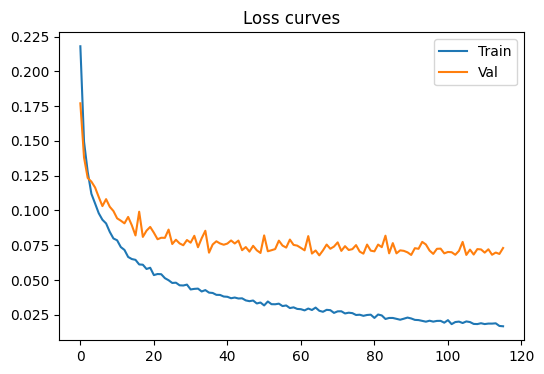

Test samples:
Sample   0: Pred=0.0916, True=0.0827
Sample   1: Pred=0.2261, True=0.2127
Sample   2: Pred=0.7340, True=0.9860
Sample   3: Pred=0.7314, True=0.6338
Sample   4: Pred=0.0256, True=0.0199
Sample   5: Pred=0.1763, True=0.1615
Sample   6: Pred=0.7606, True=1.5235
Sample   7: Pred=0.3294, True=0.2015
Sample   8: Pred=1.1278, True=0.9216
Sample   9: Pred=2.2535, True=1.0129
Sample  10: Pred=3.7170, True=6.1867
Sample  11: Pred=0.1584, True=0.1766
Sample  12: Pred=0.1630, True=0.1623
Sample  13: Pred=0.4375, True=0.3659
Sample  14: Pred=0.2062, True=0.1767
Sample  15: Pred=0.2325, True=0.2197
Sample  16: Pred=0.2364, True=0.2002
Sample  17: Pred=0.1042, True=0.2295
Sample  18: Pred=0.5866, True=0.5474
Sample  19: Pred=0.1450, True=0.0984
Sample  20: Pred=0.0467, True=0.0502
Sample  21: Pred=5.5376, True=3.2123
Sample  22: Pred=0.1080, True=0.1116
Sample  23: Pred=0.4192, True=0.5464
Sample  24: Pred=0.0472, True=0.0712
Sample  25: Pred=2.4686, True=2.1653
Sample  26: Pred=8.4473,

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▇▆▆▆▅▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁
epoch,115
train_loss,0.01672
val_loss,0.073


[INFO 03-21 15:17:22] ax.service.managed_loop: Running optimization trial 13...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

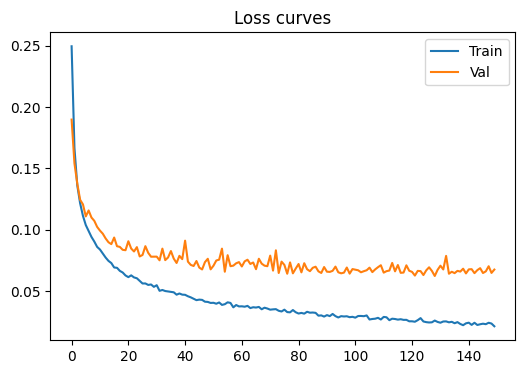

Test samples:
Sample   0: Pred=0.1040, True=0.0827
Sample   1: Pred=0.2172, True=0.2127
Sample   2: Pred=1.3907, True=0.9860
Sample   3: Pred=0.4038, True=0.6338
Sample   4: Pred=0.0253, True=0.0199
Sample   5: Pred=0.1868, True=0.1615
Sample   6: Pred=0.5959, True=1.5235
Sample   7: Pred=0.1667, True=0.2015
Sample   8: Pred=0.9896, True=0.9216
Sample   9: Pred=2.0066, True=1.0129
Sample  10: Pred=4.5827, True=6.1867
Sample  11: Pred=0.2027, True=0.1766
Sample  12: Pred=0.1244, True=0.1623
Sample  13: Pred=0.3525, True=0.3659
Sample  14: Pred=0.1962, True=0.1767
Sample  15: Pred=0.2031, True=0.2197
Sample  16: Pred=0.1823, True=0.2002
Sample  17: Pred=0.1164, True=0.2295
Sample  18: Pred=0.5460, True=0.5474
Sample  19: Pred=0.2502, True=0.0984
Sample  20: Pred=0.0327, True=0.0502
Sample  21: Pred=5.1090, True=3.2123
Sample  22: Pred=0.1014, True=0.1116
Sample  23: Pred=0.4063, True=0.5464
Sample  24: Pred=0.0488, True=0.0712
Sample  25: Pred=2.2719, True=2.1653
Sample  26: Pred=8.5997,

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███
train_loss,█▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▂▁▁▁▁
epoch,149
train_loss,0.02141
val_loss,0.0676


[INFO 03-21 15:19:17] ax.service.managed_loop: Running optimization trial 14...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

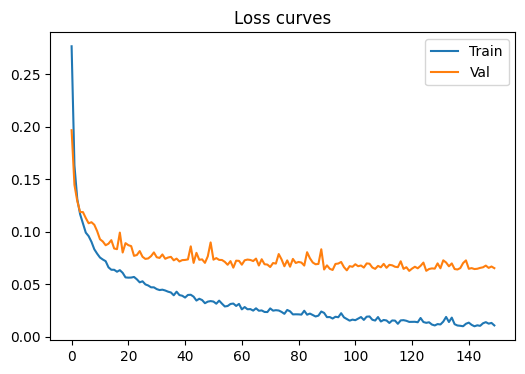

Test samples:
Sample   0: Pred=0.1118, True=0.0827
Sample   1: Pred=0.2348, True=0.2127
Sample   2: Pred=1.7200, True=0.9860
Sample   3: Pred=0.5141, True=0.6338
Sample   4: Pred=0.0211, True=0.0199
Sample   5: Pred=0.1660, True=0.1615
Sample   6: Pred=1.5640, True=1.5235
Sample   7: Pred=0.1637, True=0.2015
Sample   8: Pred=1.0186, True=0.9216
Sample   9: Pred=3.1091, True=1.0129
Sample  10: Pred=7.9066, True=6.1867
Sample  11: Pred=0.1610, True=0.1766
Sample  12: Pred=0.1315, True=0.1623
Sample  13: Pred=0.4190, True=0.3659
Sample  14: Pred=0.2207, True=0.1767
Sample  15: Pred=0.1737, True=0.2197
Sample  16: Pred=0.2019, True=0.2002
Sample  17: Pred=0.0864, True=0.2295
Sample  18: Pred=0.5653, True=0.5474
Sample  19: Pred=0.2345, True=0.0984
Sample  20: Pred=0.0486, True=0.0502
Sample  21: Pred=8.9013, True=3.2123
Sample  22: Pred=0.1037, True=0.1116
Sample  23: Pred=0.5248, True=0.5464
Sample  24: Pred=0.1007, True=0.0712
Sample  25: Pred=1.9656, True=2.1653
Sample  26: Pred=16.1995

epoch,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▃▃▄▂▂▂▂▂▂▂▂▁▁▁▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,149
train_loss,0.01069
val_loss,0.06524


[INFO 03-21 15:22:07] ax.service.managed_loop: Running optimization trial 15...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 0
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

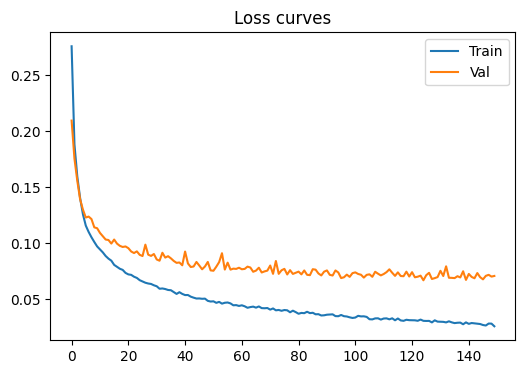

Test samples:
Sample   0: Pred=0.0668, True=0.0827
Sample   1: Pred=0.2846, True=0.2127
Sample   2: Pred=2.4497, True=0.9860
Sample   3: Pred=0.5027, True=0.6338
Sample   4: Pred=0.0255, True=0.0199
Sample   5: Pred=0.1584, True=0.1615
Sample   6: Pred=0.6410, True=1.5235
Sample   7: Pred=0.1959, True=0.2015
Sample   8: Pred=1.0946, True=0.9216
Sample   9: Pred=2.7736, True=1.0129
Sample  10: Pred=2.6572, True=6.1867
Sample  11: Pred=0.1104, True=0.1766
Sample  12: Pred=0.1538, True=0.1623
Sample  13: Pred=0.3882, True=0.3659
Sample  14: Pred=0.2350, True=0.1767
Sample  15: Pred=0.2385, True=0.2197
Sample  16: Pred=0.1291, True=0.2002
Sample  17: Pred=0.2441, True=0.2295
Sample  18: Pred=0.7084, True=0.5474
Sample  19: Pred=0.1188, True=0.0984
Sample  20: Pred=0.0384, True=0.0502
Sample  21: Pred=3.8443, True=3.2123
Sample  22: Pred=0.0954, True=0.1116
Sample  23: Pred=0.5218, True=0.5464
Sample  24: Pred=0.0600, True=0.0712
Sample  25: Pred=2.3120, True=2.1653
Sample  26: Pred=12.3594

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▆▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▁▂▂▁▁▂▂▁▂▁▁▁▁▁▂
epoch,149
train_loss,0.02595
val_loss,0.07085


[INFO 03-21 15:24:04] ax.service.managed_loop: Running optimization trial 16...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

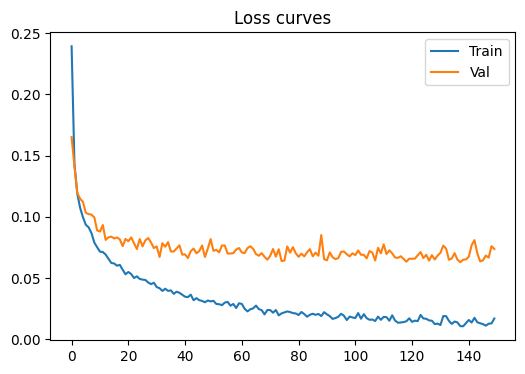

Test samples:
Sample   0: Pred=0.0899, True=0.0827
Sample   1: Pred=0.1981, True=0.2127
Sample   2: Pred=1.1964, True=0.9860
Sample   3: Pred=0.6254, True=0.6338
Sample   4: Pred=0.0186, True=0.0199
Sample   5: Pred=0.1485, True=0.1615
Sample   6: Pred=0.6637, True=1.5235
Sample   7: Pred=0.1896, True=0.2015
Sample   8: Pred=1.4596, True=0.9216
Sample   9: Pred=1.8443, True=1.0129
Sample  10: Pred=5.4351, True=6.1867
Sample  11: Pred=0.1419, True=0.1766
Sample  12: Pred=0.1472, True=0.1623
Sample  13: Pred=0.3839, True=0.3659
Sample  14: Pred=0.1887, True=0.1767
Sample  15: Pred=0.2178, True=0.2197
Sample  16: Pred=0.1984, True=0.2002
Sample  17: Pred=0.1506, True=0.2295
Sample  18: Pred=0.5784, True=0.5474
Sample  19: Pred=0.0919, True=0.0984
Sample  20: Pred=0.0367, True=0.0502
Sample  21: Pred=6.8658, True=3.2123
Sample  22: Pred=0.1042, True=0.1116
Sample  23: Pred=0.5265, True=0.5464
Sample  24: Pred=0.0980, True=0.0712
Sample  25: Pred=2.5927, True=2.1653
Sample  26: Pred=15.0482

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
train_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▃▃▃▃▃▂▂▂▃▁▃▂▂▁▁▂▁▁▂▂▂▁▂▁▂▁▁▁▂▁▂▂▁▁▂▃
epoch,149
train_loss,0.01702
val_loss,0.0737


[INFO 03-21 15:29:29] ax.service.managed_loop: Running optimization trial 17...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

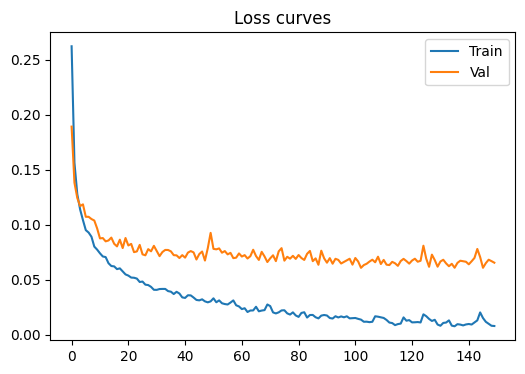

Test samples:
Sample   0: Pred=0.1494, True=0.0827
Sample   1: Pred=0.2520, True=0.2127
Sample   2: Pred=1.5026, True=0.9860
Sample   3: Pred=0.6286, True=0.6338
Sample   4: Pred=0.0319, True=0.0199
Sample   5: Pred=0.1760, True=0.1615
Sample   6: Pred=1.0125, True=1.5235
Sample   7: Pred=0.2251, True=0.2015
Sample   8: Pred=0.8539, True=0.9216
Sample   9: Pred=2.1139, True=1.0129
Sample  10: Pred=6.0515, True=6.1867
Sample  11: Pred=0.1790, True=0.1766
Sample  12: Pred=0.1554, True=0.1623
Sample  13: Pred=0.4057, True=0.3659
Sample  14: Pred=0.2124, True=0.1767
Sample  15: Pred=0.2415, True=0.2197
Sample  16: Pred=0.2496, True=0.2002
Sample  17: Pred=0.2498, True=0.2295
Sample  18: Pred=0.6011, True=0.5474
Sample  19: Pred=0.1197, True=0.0984
Sample  20: Pred=0.0499, True=0.0502
Sample  21: Pred=7.2037, True=3.2123
Sample  22: Pred=0.1235, True=0.1116
Sample  23: Pred=0.5710, True=0.5464
Sample  24: Pred=0.0910, True=0.0712
Sample  25: Pred=2.6157, True=2.1653
Sample  26: Pred=12.0393

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,█▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,█▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▁▁▂▂▃▂▁▂▁▁▁▁
epoch,149
train_loss,0.00801
val_loss,0.06549


[INFO 03-21 15:32:16] ax.service.managed_loop: Running optimization trial 18...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

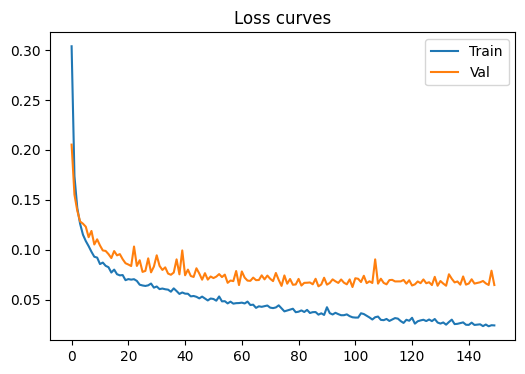

Test samples:
Sample   0: Pred=0.0670, True=0.0827
Sample   1: Pred=0.2077, True=0.2127
Sample   2: Pred=4.5690, True=0.9860
Sample   3: Pred=0.6112, True=0.6338
Sample   4: Pred=0.0309, True=0.0199
Sample   5: Pred=0.1458, True=0.1615
Sample   6: Pred=0.5530, True=1.5235
Sample   7: Pred=0.2069, True=0.2015
Sample   8: Pred=0.8922, True=0.9216
Sample   9: Pred=6.8875, True=1.0129
Sample  10: Pred=2.7423, True=6.1867
Sample  11: Pred=0.2460, True=0.1766
Sample  12: Pred=0.1479, True=0.1623
Sample  13: Pred=0.3275, True=0.3659
Sample  14: Pred=0.2202, True=0.1767
Sample  15: Pred=0.2548, True=0.2197
Sample  16: Pred=0.1444, True=0.2002
Sample  17: Pred=0.1083, True=0.2295
Sample  18: Pred=0.5259, True=0.5474
Sample  19: Pred=0.1468, True=0.0984
Sample  20: Pred=0.0390, True=0.0502
Sample  21: Pred=7.4253, True=3.2123
Sample  22: Pred=0.1031, True=0.1116
Sample  23: Pred=0.4941, True=0.5464
Sample  24: Pred=0.1009, True=0.0712
Sample  25: Pred=3.4969, True=2.1653
Sample  26: Pred=12.6850

epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇█████
train_loss,█▇▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▆▅▅▅▄▅▄▃▃▄▂▃▂▂▃▂▂▂▁▂▁▂▂▁▂▂▁▂▁▂▁▁▂▁▂▂▁
epoch,149
train_loss,0.02437
val_loss,0.06479


[INFO 03-21 15:34:59] ax.service.managed_loop: Running optimization trial 19...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 0
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

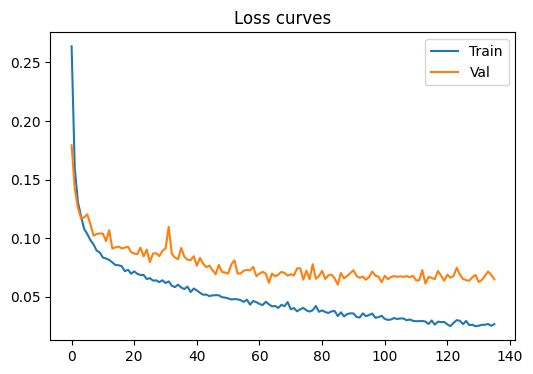

Test samples:
Sample   0: Pred=0.0753, True=0.0827
Sample   1: Pred=0.2548, True=0.2127
Sample   2: Pred=0.7446, True=0.9860
Sample   3: Pred=0.6693, True=0.6338
Sample   4: Pred=0.0134, True=0.0199
Sample   5: Pred=0.1803, True=0.1615
Sample   6: Pred=0.9028, True=1.5235
Sample   7: Pred=0.2702, True=0.2015
Sample   8: Pred=1.0609, True=0.9216
Sample   9: Pred=2.1886, True=1.0129
Sample  10: Pred=10.4869, True=6.1867
Sample  11: Pred=0.1931, True=0.1766
Sample  12: Pred=0.1706, True=0.1623
Sample  13: Pred=0.3296, True=0.3659
Sample  14: Pred=0.1727, True=0.1767
Sample  15: Pred=0.2609, True=0.2197
Sample  16: Pred=0.2154, True=0.2002
Sample  17: Pred=0.2361, True=0.2295
Sample  18: Pred=0.5171, True=0.5474
Sample  19: Pred=0.1627, True=0.0984
Sample  20: Pred=0.0404, True=0.0502
Sample  21: Pred=4.6747, True=3.2123
Sample  22: Pred=0.1141, True=0.1116
Sample  23: Pred=0.5228, True=0.5464
Sample  24: Pred=0.0942, True=0.0712
Sample  25: Pred=3.1412, True=2.1653
Sample  26: Pred=10.893

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
train_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▄▄▄▃▄▄▃▄▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▁▂▁▁▂▂▁▁
epoch,135
train_loss,0.02672
val_loss,0.06488


[INFO 03-21 15:39:53] ax.service.managed_loop: Running optimization trial 20...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 0
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

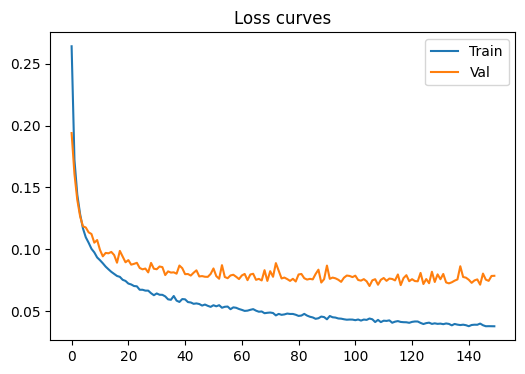

Test samples:
Sample   0: Pred=0.0742, True=0.0827
Sample   1: Pred=0.1390, True=0.2127
Sample   2: Pred=0.6674, True=0.9860
Sample   3: Pred=0.3622, True=0.6338
Sample   4: Pred=0.0235, True=0.0199
Sample   5: Pred=0.1018, True=0.1615
Sample   6: Pred=0.6088, True=1.5235
Sample   7: Pred=0.1685, True=0.2015
Sample   8: Pred=0.8084, True=0.9216
Sample   9: Pred=1.3817, True=1.0129
Sample  10: Pred=3.5679, True=6.1867
Sample  11: Pred=0.1148, True=0.1766
Sample  12: Pred=0.1211, True=0.1623
Sample  13: Pred=0.2790, True=0.3659
Sample  14: Pred=0.1653, True=0.1767
Sample  15: Pred=0.2072, True=0.2197
Sample  16: Pred=0.1290, True=0.2002
Sample  17: Pred=0.1326, True=0.2295
Sample  18: Pred=0.4487, True=0.5474
Sample  19: Pred=0.1343, True=0.0984
Sample  20: Pred=0.0372, True=0.0502
Sample  21: Pred=2.3128, True=3.2123
Sample  22: Pred=0.1334, True=0.1116
Sample  23: Pred=0.5404, True=0.5464
Sample  24: Pred=0.0581, True=0.0712
Sample  25: Pred=3.0503, True=2.1653
Sample  26: Pred=15.3457

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁
epoch,149
train_loss,0.0378
val_loss,0.07857


Best Parameters: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_size': 64, 'batch_size': 16, 'l2_lambda': 2.751971515984825e-06}
Best Validation Loss: ({'objective': 0.06111282996828715}, {'objective': {'objective': 7.470923128136445e-07}})


In [1]:
from ax import optimize
from engiopt.shape2shape_leastV_vae_hybsm import Args, main

def train_and_evaluate_model(hyperparams: dict) -> float:
    """
    Creates a new Args instance (using defaults that match your command-line call),
    updates it with hyperparameters from Ax (including l2 penalization),
    runs training, and returns the best validation loss.
    """
    args = Args(
        data_dir="../EngiOpt/data",
        data_input="power_electronics_v0_1.csv",
        init_col="",
        opt_col="",
        target_col="r",
        log_target=True,
        params_cols=["C1", "C2", "C3", "C4", "C5", "C6", "L1", "L2", "L3", "T1", "g"],
        strip_column_spaces=True,
        flatten_columns=[],  # no flattening for PE dataset
        lambda_lv=1e-2,
        learning_rate=1e-3,   # default; will be overwritten
        structured=False,     # plain MLP mode
        hidden_layers=2,      # default; will be overwritten
        hidden_size=128,      # default; will be overwritten
        latent_dim=8,
        n_epochs=150,
        batch_size=64,        # default; will be overwritten
        patience=50,
        l2_lambda=1e-3,       # default; will be overwritten
        scale_target=True,
        track=True,
        wandb_project="shape2shape_leastV_vae_hybsm_pe_BO",
        seed=18,
        save_model=True,
        model_output_dir="my_models",
        test_model=True
    )
    # Update hyperparameters from Ax.
    args.learning_rate = hyperparams["learning_rate"]
    args.hidden_layers = int(hyperparams["hidden_layers"])
    args.hidden_size = int(hyperparams["hidden_size"])
    args.batch_size = int(hyperparams["batch_size"])
    args.l2_lambda = hyperparams["l2_lambda"]  # NEW: update the L2 penalty weight.
    
    # Run training; main(args) must return best_val_loss.
    best_val_loss = main(args)
    return best_val_loss

# Now run the Ax high-level optimize function with the additional hyperparameter.
best_parameters, best_values, experiment, model = optimize(
    parameters=[
        {
            "name": "learning_rate",
            "type": "range",
            "bounds": [1e-4, 1e-3],
            "log_scale": True,
        },
        {
            "name": "hidden_layers",
            "type": "choice",
            "values": [2, 3, 4],
        },
        {
            "name": "hidden_size",
            "type": "choice",
            "values": [32, 64, 128],
        },
        {
            "name": "batch_size",
            "type": "choice",
            "values": [8, 16, 32, 64, 128],
        },
        {
            "name": "l2_lambda",           # NEW: L2 penalty hyperparameter.
            "type": "range",
            "bounds": [1e-6, 1e-3],
            "log_scale": True,
        },
    ],
    evaluation_function=train_and_evaluate_model,
    minimize=True,
    total_trials=20,
)

print("Best Parameters:", best_parameters)
print("Best Validation Loss:", best_values)


In [2]:
# better cause circuit as categorical values so dimless i think not needed
!python ./engiopt/shape2shape_leastV_vae_hybsm.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --l2_lambda 2.751971515984825e-06\
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 1e-3 \
    --no-structured \
    --hidden_layers 4 \
    --hidden_size 64 \
    --latent_dim 8 \
    --n_epochs 1000 \
    --batch_size 16 \
    --patience 400 \
    --scale_target \
    --track \
    --wandb_project "shape2shape_leastV_vae_hybsm_pe_Best"\
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

wandb: Currently logged in as: smassoudi (smassoudi-eth-z-rich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.5
wandb: Run data is saved locally in /Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/wandb/run-20250321_154901-znhgetll
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run power_electronics_v0_1.csv__seed18__2025-03-21-15-49-01
wandb: ⭐️ View project at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe_Best
wandb: 🚀 View run at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe_Best/runs/znhgetll
Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001  ...  0.2  0.410832  1.152453  -9.022484
2  0.000001  0.000001  0.000001  0.000001  ...  0.3  0.353193  1

In [30]:
import sys
import os

# Add the path to the directory containing your AutoGluon script
sys.path.append(os.path.abspath("../EngiOpt/engiopt"))

# Now you can import and use the script as if it's in the same directory
#from autogluon_multimodal import main


# CHECKED:

# data_dir
# data_input
# input_cols
# target_col
# flatten_columns
# hidden_layers
# activation
# optimizer
# learning_rate
# n_epochs
# batch_size
# patience
# scale_target
# wandb_project
# seed
# save_model
# track
# model_output_dir
# wandb_project



!python ./engiopt/shape2shape_leastV_vae.py \
    --data_dir "../EngiOpt/data" \
    --data_input "airfoil_data.csv" \
    --init_col "optimal_design" \
    --opt_col "optimal_design" \
    --target_col "cl_val" \
    --params_cols '["mach","reynolds","alpha"]' \
    --flatten_columns '["initial_design","optimal_design"]' \
    --lambda_lv 1e-2 \
    --learning_rate 1e-4 \
    --gamma 1.0 \
    --structured \
    --hidden_layers 3 \
    --hidden_size 32 \
    --latent_dim 8 \
    --n_epochs 50 \
    --batch_size 32 \
    --patience 40 \
    --scale_target \
    --no-track \
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

Using device: mps
                                      initial_design  ...  area_con
0  [[0.9999864252928555, 0.9893170986509016, 0.97...  ...  0.832122
1  [[1.000000037209308, 0.9895321097704624, 0.979...  ...  0.887370
2  [[0.9999947929941965, 0.9893335711523464, 0.97...  ...  0.966670
3  [[0.9999964309108346, 0.9893222342558019, 0.97...  ...  0.938907
4  [[1.0000056013070746, 0.9893170615343417, 0.97...  ...  0.900123

[5 rows x 12 columns]
After flattening, df.columns: ['mach', 'reynolds', 'cl_target', 'area_target', 'alpha', 'area_initial', 'cd_val', 'cl_val', 'cl_con', 'area_con', 'initial_design_0', 'initial_design_1', 'initial_design_2', 'initial_design_3', 'initial_design_4', 'initial_design_5', 'initial_design_6', 'initial_design_7', 'initial_design_8', 'initial_design_9', 'initial_design_10', 'initial_design_11', 'initial_design_12', 'initial_design_13', 'initial_design_14', 'initial_design_15', 'initial_design_16', 'initial_design_17', 'initial_design_18', 'initial_design_